In [704]:
from glob import glob
import os
import pandas as pd
from pathlib import Path

In [705]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline
from preprocessing.initial_preprocessing import initial_preprocessing
from preprocessing.drop_emergency_suspicious_height_wight import drop_emergency_suspicious_height_weight
from preprocessing.duplicated_accession_CTDImax import duplicated_accession_CTDImax
from preprocessing.calculate_bmi_bmr_category import calculate_bmi_bmr_category

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## データクリーニング

In [706]:
df = pd.read_excel('train_data.xlsx')
initial_preprocessing(df)
df = duplicated_accession_CTDImax(df)
# df.reset_index(drop=True, inplace=True)
df = drop_emergency_suspicious_height_weight(df)
df.head(3)

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,exposure time per rotation,exposure time,CTDIw phantom type,Mean CTDIvol,DLP,scan_date,id,age,department,hospital_ward,gender,height(cm),weight(kg),scan_order,preset_name,modality,scan_method,adult_child
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80.0,0.5,1.74,IEC Body Dosimetry Phantom,5.86,223.82,2021-01-01,12585,86,感染症内科,外来,F,150.0,49.1,胸部CT,256列 【枠外】胸部CT（単純）,Revolution,単純,成人
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80.0,0.5,2.01,IEC Body Dosimetry Phantom,7.41,327.55,2021-01-01,2145609,61,感染症内科,外来,M,163.0,74.0,胸部CT,256列 【枠外】胸部CT（単純）,Revolution,単純,成人
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80.0,0.5,2.12,IEC Body Dosimetry Phantom,5.13,239.47,2021-01-02,12615,46,感染症内科,外来,M,178.0,68.0,胸部CT,256列 【枠外】胸部CT（単純）,Revolution,単純,成人


In [707]:
len(df)

8922

In [708]:
# 身長を昇順で表示

df['height(cm)'].sort_values()

97      101.0
1193    101.0
262     101.0
1005    101.0
2351    101.0
        ...  
7943    190.9
8574    190.9
785     193.0
8       193.0
5543    193.0
Name: height(cm), Length: 8922, dtype: float64

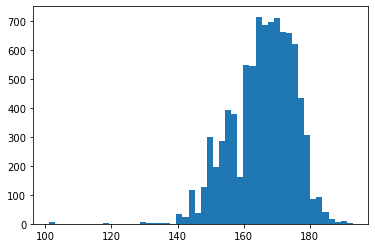

In [709]:
plt.hist(df['height(cm)'], bins=50);

* データには1回の検査で複数のスキャン情報が含まれているため、その中から予測したいCTDIvolの最大値のみを取り出す

In [710]:
unique_data_num = len(df['accession'].unique())
unique_data_num

8922

In [711]:
df_duplicated = df[df['accession'].duplicated(keep=False)]

df_not_duplicated = df[~df['accession'].duplicated(keep=False)]

max_indices = df_duplicated.groupby('accession')['Mean CTDIvol'].idxmax()

result_df = df_duplicated.loc[max_indices].reset_index(drop=True)

df = pd.concat([df_not_duplicated, result_df], axis=0)

In [712]:
len(df)

8922

In [713]:
df.reset_index(drop=True, inplace=True)

In [714]:
df.head(3)

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,exposure time per rotation,exposure time,CTDIw phantom type,Mean CTDIvol,DLP,scan_date,id,age,department,hospital_ward,gender,height(cm),weight(kg),scan_order,preset_name,modality,scan_method,adult_child
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80.0,0.5,1.74,IEC Body Dosimetry Phantom,5.86,223.82,2021-01-01,12585,86,感染症内科,外来,F,150.0,49.1,胸部CT,256列 【枠外】胸部CT（単純）,Revolution,単純,成人
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80.0,0.5,2.01,IEC Body Dosimetry Phantom,7.41,327.55,2021-01-01,2145609,61,感染症内科,外来,M,163.0,74.0,胸部CT,256列 【枠外】胸部CT（単純）,Revolution,単純,成人
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80.0,0.5,2.12,IEC Body Dosimetry Phantom,5.13,239.47,2021-01-02,12615,46,感染症内科,外来,M,178.0,68.0,胸部CT,256列 【枠外】胸部CT（単純）,Revolution,単純,成人


In [715]:
#　最終的な怪しいデータに関しては直接データを確認して削除する

drop_ids = [75206, 9326611, 17049]
for ids in drop_ids:
    df = df[~(df['id'] == ids)]
df.reset_index(drop=True, inplace=True)

In [613]:
len(df)

8947

In [716]:
#身長体重予測、線量予測、異常検知でも使用しない項目を削除する

unuse_cols = ['hospital_ward', 'modality', 'adult_child', 'department', 'preset_name']
df.drop(labels=unuse_cols, axis=1, inplace=True)

In [717]:
df.columns

Index(['accession', 'scan protocol', 'scan series', 'target region',
       'scanning length', 'kV', 'mean mA', 'max mA', 'pitch factor',
       'nomial total collimation width', 'exposure time per rotation',
       'exposure time', 'CTDIw phantom type', 'Mean CTDIvol', 'DLP',
       'scan_date', 'id', 'age', 'gender', 'height(cm)', 'weight(kg)',
       'scan_order', 'scan_method'],
      dtype='object')

In [718]:
df.to_excel('preprocess_all_scan_data.xlsx')

## 新たな特徴量を作成

* BMI(Body Mass Index)  
  $BMI = weight(kg) / height(m)^2$  
  
* BMR(Basal Metabolic Rate: 基礎代謝率): 年齢、性別、身長、体重に基づいて計算される。ハリス・ベネディクト方程式と呼ばれる  
  男性$BMR=66.47 + (13.75*weight[kg]) + (5.003*height[cm]) - (6.755*age[歳])$  
  女性$BMR=655.1 + (9.563*weight[kg]) + (1.85*height[cm]) - (4.676*age[歳])$  
  
* 体格指数(Rohrer's index) ：学童期に適するとあるので、今回は使わない  
  $Rohrer's index = weight[kg] / height[m]^3$
  
 体格指数（BMI）: 体重（kg）を身長（m）の二乗で割ったもので、以下のように分類されます（成人向けのWHOのガイドライン）。

18.5未満: 低体重（痩せ型）: underweight    
18.5～24.9: 標準体重: normal weight   
25.0～29.9: 肥満（1度）:obesity class1  
30.0～34.9: 肥満（2度）:obesity class2  
35.0～39.9: 肥満（3度）:obesity class3    
40以上: 肥満（4度、重症）:obesity class4

In [719]:
df['bmi'] = round(df['weight(kg)'] / (df['height(cm)']/100)**2, ndigits=2)

In [720]:
men_idx = df[df['gender']=='M'].index.to_list()

In [721]:
woman_idx = df[df['gender']=='F'].index.to_list()

df.loc[men_idx, ['bmr']] = round(66.47 + (13.75 * df[df['gender'] == 'M']['weight(kg)']) + (5.003 * df[df['gender']=='M']['height(cm)']) - (6.755 * df[df['gender']=='M']['age']), ndigits=2)

df.loc[woman_idx, ['bmr']] = round(655.1 + (9.563 * df[df['gender'] == 'F']['weight(kg)']) + (1.85 * df[df['gender']=='F']['height(cm)']) - (4.676 * df[df['gender']=='F']['age']), ndigits=2)

In [722]:
df.loc[1]

accession                                   1103161620210101
scan protocol                           5.1 QQ Chest Routine
scan series                                              NaN
target region                                          Chest
scanning length                                        442.2
kV                                                       100
mean mA                                               442.93
max mA                                                   700
pitch factor                                            1.38
nomial total collimation width                          80.0
exposure time per rotation                               0.5
exposure time                                           2.01
CTDIw phantom type                IEC Body Dosimetry Phantom
Mean CTDIvol                                            7.41
DLP                                                   327.55
scan_date                                2021-01-01 00:00:00
id                      

In [723]:
calculate_bmi_bmr_category(df)

In [86]:
df.to_excel('preprocessed_train_data.xlsx', index=False)

In [724]:
# スキャンのオーダーが頭部ではないのにファントムタイプが頭部用のデータを削除

df = df[~((df['CTDIw phantom type'] == 'IEC Head Dosimetry Phantom') & (df['scan_order'] == '頸部CT'))]
df = df[~((df['CTDIw phantom type'] == 'IEC Head Dosimetry Phantom') & (df['scan_order'] == '頸部〜骨盤CT'))]
df = df[~((df['CTDIw phantom type'] == 'IEC Head Dosimetry Phantom') & (df['scan_order'] == '胸部〜骨盤CT'))]
df = df[~((df['CTDIw phantom type'] == 'IEC Head Dosimetry Phantom') & (df['scan_order'] == '胸部CT'))]

In [725]:
# 消えているか確認

df[((df['CTDIw phantom type'] == 'IEC Head Dosimetry Phantom') & (df['scan_order'] == '頸部CT'))]

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,exposure time per rotation,exposure time,CTDIw phantom type,Mean CTDIvol,DLP,scan_date,id,age,gender,height(cm),weight(kg),scan_order,scan_method,bmi,bmr,category_bmi


In [726]:
# 年齢の下一桁を切り捨てて、世代ごとのグループ分けをする

df['age_era'] = (df['age'] // 10) * 10

In [80]:
df['age_era'].head(3)

0    80
1    60
2    40
Name: age_era, dtype: int64

In [89]:
import pandas as pd
df = pd.read_excel('preprocessed_train_data.xlsx')
df

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,exposure time per rotation,exposure time,CTDIw phantom type,Mean CTDIvol,DLP,scan_date,id,age,gender,height(cm),weight(kg),scan_order,scan_method,bmi,bmr,category_bmi,age_era
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,0.5,1.74,IEC Body Dosimetry Phantom,5.86,223.82,2021-01-01,12585,86,F,150.0,49.1,胸部CT,単純,21.82,1000.01,normal weight,80
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,0.5,2.01,IEC Body Dosimetry Phantom,7.41,327.55,2021-01-01,2145609,61,M,163.0,74.0,胸部CT,単純,27.85,1487.40,obecity class1,60
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,0.5,2.12,IEC Body Dosimetry Phantom,5.13,239.47,2021-01-02,12615,46,M,178.0,68.0,胸部CT,単純,21.46,1581.27,normal weight,40
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,0.5,2.15,IEC Body Dosimetry Phantom,7.25,342.20,2021-01-02,12616,52,M,182.0,70.0,胸部CT,単純,21.13,1588.26,normal weight,50
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,0.5,2.10,IEC Body Dosimetry Phantom,11.56,534.33,2021-01-03,9595120,52,M,175.0,112.0,胸部CT,単純,36.57,2130.73,obecity class3,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8931,1364925420230425,"5.12 Chest - Pelvis (40sec,80sec)Routine",CE,Chest,916.19,100,450.77,700,0.99,80,0.8,9.23,IEC Body Dosimetry Phantom,16.73,1532.94,2023-04-25,3026311,48,M,166.0,71.0,胸部〜骨盤CT,造影,25.77,1548.98,obecity class1,40
8932,1365245120230426,6.2 Abdomen-Pelvis Routine,Plain,Abdomen and Pelvis,626.27,100,414.06,720,0.99,80,0.8,6.31,IEC Body Dosimetry Phantom,15.37,962.52,2023-04-26,7586107,36,M,174.0,73.4,腹部〜骨盤CT,造影,24.24,1703.06,normal weight,30
8933,1365256720230426,"5.36 GSIX Aorta CTA prep (CTA, +20s) Delay onl...",CTA,Chest,5.00,100,100.00,100,1.00,5,1.0,7.58,IEC Body Dosimetry Phantom,52.55,26.28,2023-04-26,6346212,44,M,171.0,65.0,左上肢ｼｬﾝﾄCT,Dual Energy,22.23,1518.51,normal weight,40
8934,1365967020230428,"6.4 HCC 3Phase (40sec,70sec,180sec) Routine",CE,Abdomen,551.66,100,354.37,720,0.99,80,0.6,4.17,IEC Body Dosimetry Phantom,9.87,544.21,2023-04-28,3116205,50,M,176.5,56.2,腹部〜骨盤CT,造影,18.04,1384.50,under weight,50


In [727]:
# 体重が重い順に１２個データを表示

df.sort_values(by=['weight(kg)'], ascending=False)[:12][['accession', 'scan protocol', 'scan series', 'Mean CTDIvol', 'bmi', 'weight(kg)']]

,accession,scan protocol,scan series,Mean CTDIvol,bmi,weight(kg)
4316,1249030520220420,5.16 QQ Full FOV Chest - Pelvis 80cm,Plain,75.25,53.15,172.2
8824,1348835920230307,5.7 QQ Full FOV Chest - Pelvis 80cm,Plain,106.63,50.72,151.8
6907,1361384220230416,5.28 GSIX Chest-Pelvis CEonly,CE Dual Energy,41.43,50.72,151.8
6805,1355672120230329,5.28 GSIX Chest-Pelvis CEonly,CE Dual Energy,41.43,50.72,151.8
8844,1351460220230315,5.7 QQ Full FOV Chest - Pelvis 80cm,CE,34.94,50.72,151.8
8803,1346485720230228,6.2 Abdomen-Pelvis Routine,CE,61.33,50.72,151.8
7636,1229782420220221,"5.9 Chest - Pelvis Dynamic (40sec,70sec,180sec...",Plain,60.64,41.93,146.0
3459,1217692720220118,5.1 QQ Chest Routine,Plain,21.72,44.94,145.6
887,1145002420210504,5.1 QQ Chest Routine,NaN,17.17,37.33,125.0
8,1103770520210104,5.1 QQ Chest Routine,NaN,16.31,33.02,123.0


In [728]:
# 外れ値として扱うデータを選び、削除するリストに追加する

drop_accession_list = [1249030520220420, 1351460220230315, 1346485720230228, 1348835920230307,
                       1229782420220221]
for accession in drop_accession_list:
    df = df[~(df['accession'] == accession)]
df.reset_index(drop=True, inplace=True)

In [731]:
len(df)

8862

differenceが10以上のデータを確認した中で、以下のようなデータを削除
*脳でHead restを使用せずベッドで撮影したデータ
*オーダーに対して不適切な部位が撮影範囲に含まれている（脳CTで肩が含まれている等）
*腕を挙上していない（体幹部撮影の際）
*上肢撮影で体幹が含まれている
*金属等が装着されている
*オーダーと撮影部位が異なる

In [729]:
drop_accession_list = [1219548120220124, 1364809020230425, 1117860420210215, 1249639320220422, 1335762120230126, 1291697020220912, 
                       1359568020230411, 1190377920211012, 1262435120220608, 1347736320230303, 1289845120220906, 1223184520220202,
                       1330730720230113, 1327520120230104, 1197756320211109, 1129424720210322, 1309065120221107, 1343513920230218,
                       1198504120211111, 1208625320211216, 1358077220230406, 1130613820210324, 1223603420220203, 1197519820211108,
                       1105253820210108, 1140475720210420, 1335584020230126, 1293219420220916, 1144301520210430, 1111324820210125,
                       1338397620230204, 1164256820210709, 1323580920221220]

for accession in drop_accession_list:
    df.drop(df[df['accession'] == accession].index, axis=0, inplace=True)

In [103]:
prep_accession_list = [1240856520220326, 1120318520210222, 1323581020221220, 1301456820221014, 1096936920201214, 1323654920221220, 1258489920220524]

update_MeanCTDI_list = [21.33, 19.16, 36.24, 6.84, 23.27, 8.92, 16.43]

for accession, MeanCTDI in zip(prep_accession_list, update_MeanCTDI_list):
    df.loc[df[df['accession'] == accession].index, 'Mean CTDIvol'] = MeanCTDI

In [102]:
df.to_excel('preprocessed_train_data.xlsx', index=False)

In [645]:
df = pd.read_excel('preprocessed_train_data.xlsx')
df

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,exposure time per rotation,exposure time,CTDIw phantom type,Mean CTDIvol,DLP,scan_date,id,age,gender,height(cm),weight(kg),scan_order,scan_method,bmi,bmr,category_bmi,age_era
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,0.5,1.74,IEC Body Dosimetry Phantom,5.86,223.82,2021-01-01,12585,86,F,150.0,49.1,胸部CT,単純,21.82,1000.01,normal weight,80
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,0.5,2.01,IEC Body Dosimetry Phantom,7.41,327.55,2021-01-01,2145609,61,M,163.0,74.0,胸部CT,単純,27.85,1487.40,obecity class1,60
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,0.5,2.12,IEC Body Dosimetry Phantom,5.13,239.47,2021-01-02,12615,46,M,178.0,68.0,胸部CT,単純,21.46,1581.27,normal weight,40
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,0.5,2.15,IEC Body Dosimetry Phantom,7.25,342.20,2021-01-02,12616,52,M,182.0,70.0,胸部CT,単純,21.13,1588.26,normal weight,50
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,0.5,2.10,IEC Body Dosimetry Phantom,11.56,534.33,2021-01-03,9595120,52,M,175.0,112.0,胸部CT,単純,36.57,2130.73,obecity class3,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8926,1364925420230425,"5.12 Chest - Pelvis (40sec,80sec)Routine",CE,Chest,916.19,100,450.77,700,0.99,80,0.8,9.23,IEC Body Dosimetry Phantom,16.73,1532.94,2023-04-25,3026311,48,M,166.0,71.0,胸部〜骨盤CT,造影,25.77,1548.98,obecity class1,40
8927,1365245120230426,6.2 Abdomen-Pelvis Routine,Plain,Abdomen and Pelvis,626.27,100,414.06,720,0.99,80,0.8,6.31,IEC Body Dosimetry Phantom,15.37,962.52,2023-04-26,7586107,36,M,174.0,73.4,腹部〜骨盤CT,造影,24.24,1703.06,normal weight,30
8928,1365256720230426,"5.36 GSIX Aorta CTA prep (CTA, +20s) Delay onl...",CTA,Chest,5.00,100,100.00,100,1.00,5,1.0,7.58,IEC Body Dosimetry Phantom,52.55,26.28,2023-04-26,6346212,44,M,171.0,65.0,左上肢ｼｬﾝﾄCT,Dual Energy,22.23,1518.51,normal weight,40
8929,1365967020230428,"6.4 HCC 3Phase (40sec,70sec,180sec) Routine",CE,Abdomen,551.66,100,354.37,720,0.99,80,0.6,4.17,IEC Body Dosimetry Phantom,9.87,544.21,2023-04-28,3116205,50,M,176.5,56.2,腹部〜骨盤CT,造影,18.04,1384.50,under weight,50


### CTDIvol計算

In [660]:
def calc_ctdi(kV, mA, rot_time, pitch_factor):
    """
    この関数を用いて心臓系のCTの2回スキャンとprepスキャンの加算データ判定する
    """
    # CTDIvolを計算するための基本値
    PERI_CTDI_100 = 35.23
    CENT_CTDI_100 = 16.75
    covarage_coef_peri = 0.93
    covarage_coef_center = 0.94
    base_mA = 400
    
    kV = int(kV)
    
    if kV == 100:
        coef_peripheral_kV = 0.65
        coef_center_kV = 0.59
    elif kV == 140:
        coef_peripheral_kV = 1.41
        coef_center_kV = 1.49
    else:
        coef_peripheral_kV = 1.0
        coef_center_kV = 1.0

        
    CTDI_PERI_100 = PERI_CTDI_100 * coef_peripheral_kV * covarage_coef_peri * mA / base_mA * rot_time
    CTDI_CENT_100 = CENT_CTDI_100 * coef_center_kV * covarage_coef_center * mA / base_mA * rot_time
    
    return (CTDI_CENT_100 / 3 + 2 * CTDI_PERI_100 / 3) / pitch_factor

In [655]:
calc_ctdi(100, 500, 1, 1)

21.617758333333338

In [656]:
test = df.loc[0]

In [657]:
test

accession                                   1103161420210101
scan protocol                           5.1 QQ Chest Routine
scan series                                              NaN
target region                                          Chest
scanning length                                       382.14
kV                                                       100
mean mA                                               350.24
max mA                                                   640
pitch factor                                            1.38
nomial total collimation width                            80
exposure time per rotation                               0.5
exposure time                                           1.74
CTDIw phantom type                IEC Body Dosimetry Phantom
Mean CTDIvol                                            5.86
DLP                                                   223.82
scan_date                                2021-01-01 00:00:00
id                      

In [832]:
df['scan_order'].unique()

array(['胸部CT', '胸部〜骨盤CT', '腹部〜骨盤CT', '副鼻腔CT', '腰椎・腰髄CT', '右膝関節CT',
       'DICCT（造影）', '左膝関節CT', '顔面骨CT', '上腹部CT', '側頭骨CT', '両膝関節CT',
       '左足・趾CT', '左足関節CT', '左肩関節CT', '左下腿CT', '頸部〜骨盤CT', '左手関節CT', '鎖骨CT',
       '頸椎・頚髄CT', '頸部CT', 'その他下肢CT', '左肘関節CT', '右肩関節CT', '胸椎・胸髄CT',
       '歯・顎骨CT', '右手・指CT', '右足・趾CT', '頸部〜胸部CT', '骨盤骨CT', '右足関節CT',
       '右下腿CT', '右上腕CT', '右手関節CT', '右肘関節CT', '胸骨CT', '左大腿CT', '左手・指CT',
       '冠動脈CT（解析）', '肺静脈CT（ｶﾙﾄ）', '肺塞栓CT（胸部+下肢）', '脳CT', '両大腿CT', '左前腕CT',
       '両足関節CT', '両足・趾CT', '仙椎・尾骨CT', '肺塞栓CT（胸部のみ）', '脳・顔面骨CT', '右大腿CT',
       'その他上肢', '左上腕CT', '副鼻腔CT（ﾅﾋﾞｹﾞｰｼｮﾝ）', '脳CTA', '冠動脈CT（ﾊﾞｲﾊﾟｽ有り）',
       '肺静脈CT（ｶﾙﾄ+解析あり）', '左上肢ｼｬﾝﾄCT'], dtype=object)

<AxesSubplot:>

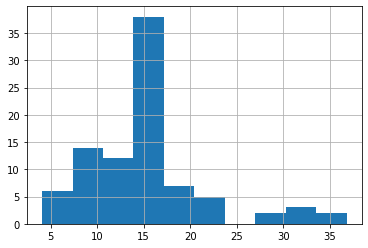

In [836]:
df[df['scan_order'].str.contains('肺塞栓CT')]

In [863]:
df_brain = df[df['scan_order'].str.contains('脳CT$')].sort_values('Mean CTDIvol', ascending=False)
df_brain.to_excel('brain_check_head_rest.xlsx', index=False)

<AxesSubplot:xlabel='mean mA', ylabel='max mA'>

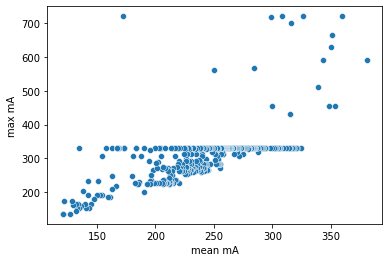

In [855]:
sns.scatterplot(x=df_brain['mean mA'], y=df_brain['max mA'])

In [839]:
df[df['scan_order'].str.contains('肺塞栓')].sort_values('Mean CTDIvol', ascending=False)[:15]

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,exposure time per rotation,exposure time,CTDIw phantom type,Mean CTDIvol,DLP,scan_date,id,age,gender,height(cm),weight(kg),scan_order,scan_method,bmi,bmr,category_bmi,age_era
8659,1330794120230113,5.29 GSIX PE+ DVT Routine,PE DVT,Chest,437.73,140,480.00,550,0.51,80.0,0.8,8.62,IEC Body Dosimetry Phantom,36.82,1611.94,2023-01-13,8895003,54,M,171.8,78.95,肺塞栓CT（胸部+下肢）,Dual Energy,26.75,1646.78,obecity class1,50
1914,1110493820210122,5.24 GSIX PE+ DVT Routine,NaN,Chest,447.64,140,439.30,435,0.51,80.0,0.8,8.82,IEC Body Dosimetry Phantom,33.56,1502.08,2021-01-22,12755,51,M,177.0,113.00,肺塞栓CT（胸部+下肢）,Dual Energy,36.07,2161.25,obecity class3,50
2154,1134714120210405,5.24 GSIX PE+ DVT Routine,NaN,Chest,442.41,140,356.66,355,0.51,80.0,1.0,10.89,IEC Body Dosimetry Phantom,33.42,1478.43,2021-04-05,15126,72,M,170.0,83.00,肺塞栓CT（胸部+下肢）,Dual Energy,28.72,1571.87,obecity class1,70
2184,1137155320210412,5.24 GSIX PE+ DVT Routine,NaN,Chest,402.39,140,356.74,355,0.51,80.0,1.0,9.91,IEC Body Dosimetry Phantom,33.42,1344.70,2021-04-12,14770,49,M,179.0,92.00,肺塞栓CT（胸部+下肢）,Dual Energy,28.71,1896.01,obecity class1,40
2087,1127883120210317,5.24 GSIX PE+ DVT Routine,NaN,Chest,457.23,140,356.71,355,0.51,80.0,1.0,11.26,IEC Body Dosimetry Phantom,33.42,1527.98,2021-03-17,7685207,54,M,168.0,85.10,肺塞栓CT（胸部+下肢）,Dual Energy,30.15,1712.33,obecity class2,50
2162,1135264120210406,5.24 GSIX PE+ DVT Routine,NaN,Chest,427.58,140,314.78,315,0.51,80.0,1.0,10.53,IEC Body Dosimetry Phantom,29.34,1254.58,2021-04-12,764703,77,M,161.0,72.00,肺塞栓CT（胸部+下肢）,Dual Energy,27.78,1341.82,obecity class1,70
2463,1170000320210729,5.24 GSIX PE+ DVT Routine,NaN,Chest,442.41,140,314.65,315,0.51,80.0,1.0,10.89,IEC Body Dosimetry Phantom,29.34,1298.09,2021-07-29,5035,82,M,167.0,55.90,肺塞栓CT（胸部+下肢）,Dual Energy,20.04,1116.69,normal weight,80
1955,1113828720210201,5.24 GSIX PE+ DVT Routine,NaN,Chest,431.40,140,478.61,475,0.99,80.0,1.0,5.44,IEC Body Dosimetry Phantom,23.27,1003.95,2021-02-01,12962,70,M,174.0,65.50,肺塞栓CT（胸部+下肢）,Dual Energy,21.63,1364.77,normal weight,70
2310,1150805520210524,5.24 GSIX PE+ DVT Routine,NaN,Chest,381.40,140,478.65,475,0.99,80.0,1.0,4.81,IEC Body Dosimetry Phantom,23.27,887.58,2021-05-24,13787,67,F,155.0,66.10,肺塞栓CT（胸部+下肢）,Dual Energy,27.51,1260.67,obecity class1,60
2447,1168610720210726,5.24 GSIX PE+ DVT Routine,NaN,Chest,572.41,140,230.50,230,0.51,80.0,1.0,14.09,IEC Body Dosimetry Phantom,21.25,1216.25,2021-07-26,18264,60,M,172.0,74.00,肺塞栓CT（胸部+下肢）,Dual Energy,25.01,1539.19,obecity class1,60


In [744]:
df['scan_order'].value_counts().sort_values()

左上肢ｼｬﾝﾄCT              1
左上腕CT                  1
仙椎・尾骨CT                1
右上腕CT                  2
左前腕CT                  2
両足関節CT                 2
両足・趾CT                 2
胸骨CT                   2
右大腿CT                  2
肺静脈CT（ｶﾙﾄ+解析あり）        2
左下腿CT                  3
左大腿CT                  3
肺塞栓CT（胸部のみ）            3
右下腿CT                  3
その他上肢                  3
両大腿CT                  3
脳・顔面骨CT                4
両膝関節CT                 5
副鼻腔CT（ﾅﾋﾞｹﾞｰｼｮﾝ）       6
左肘関節CT                 8
胸椎・胸髄CT                8
右足・趾CT                 8
右肘関節CT                11
左手・指CT                12
右足関節CT                13
右手関節CT                14
冠動脈CT（ﾊﾞｲﾊﾟｽ有り）       14
左足・趾CT                16
右手・指CT                18
右肩関節CT                19
左手関節CT                20
左足関節CT                20
左肩関節CT                24
右膝関節CT                24
骨盤骨CT                 26
その他下肢CT               28
脳CTA                  29
鎖骨CT                  30
左膝関節CT                32
DICCT（造影）             33


8301     1.071429
7127     1.071429
7959     1.071429
8787     1.071429
1826     1.071429
          ...    
7845     6.464286
8494     6.571429
8537     8.000000
8552     9.321429
8580    12.892857
Length: 294, dtype: float64

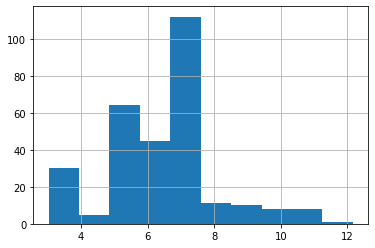

In [733]:
df_heart = df[df['scan_order'] == '冠動脈CT（解析）']

(df_heart['Mean CTDIvol'] / (df_heart['exposure time'] / df_heart['exposure time per rotation'])).hist()

(df_heart['exposure time'] / df_heart['exposure time per rotation']).sort_values()



7347     3.035714
7733     3.071429
7997     3.107143
8809     3.321429
8703     3.357143
7051     3.714286
7094     4.821429
8154     5.000000
7994     5.107143
7352     5.464286
7101     5.821429
7445     6.285714
8576     8.107143
8807    22.212500
dtype: float64

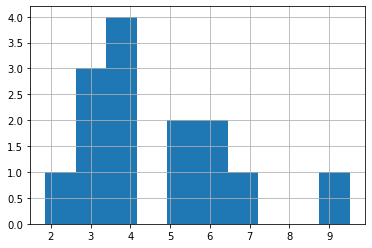

In [735]:
df_heart = df[df['scan_order'] == '冠動脈CT（ﾊﾞｲﾊﾟｽ有り）']

(df_heart['Mean CTDIvol'] / (df_heart['exposure time'] / df_heart['exposure time per rotation'])).hist()

(df_heart['exposure time'] / df_heart['exposure time per rotation']).sort_values()

7798    1.071429
8455    1.071429
dtype: float64

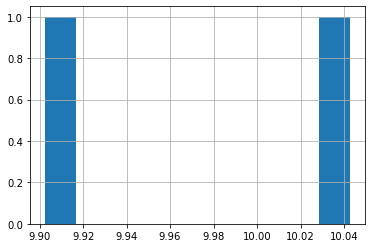

In [736]:
df_heart = df[df['scan_order'] == '肺静脈CT（ｶﾙﾄ+解析あり）']

(df_heart['Mean CTDIvol'] / (df_heart['exposure time'] / df_heart['exposure time per rotation'])).hist()

(df_heart['exposure time'] / df_heart['exposure time per rotation']).sort_values()

1792     1.071429
7963     1.071429
7924     1.071429
7896     1.071429
7766     1.071429
          ...    
8238     4.035714
2027     5.142857
8245     5.321429
7496     8.535714
1875    15.892857
Length: 110, dtype: float64

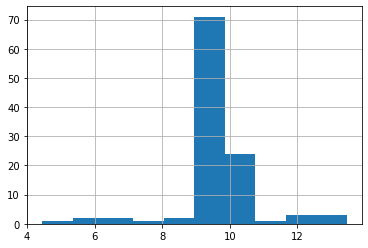

In [737]:
df_heart = df[df['scan_order'] == '肺静脈CT（ｶﾙﾄ）']

(df_heart['Mean CTDIvol'] / (df_heart['exposure time'] / df_heart['exposure time per rotation'])).hist()

(df_heart['exposure time'] / df_heart['exposure time per rotation']).sort_values()

In [671]:
test = df_heart.iloc[0]
print(f"exposure_time / rotation_time: {calc_ctdi(test['kV'], test['mean mA'], test['exposure time per rotation'], test['pitch factor']) * test['exposure time'] / test['exposure time per rotation']}")
print(f"One scan CTDIvol             : {calc_ctdi(test['kV'], test['mean mA'], test['exposure time per rotation'], test['pitch factor'])}")

exposure_time / rotation_time: 56.88911104380001
One scan CTDIvol             : 10.836021151200002


In [674]:
55.25 / (1.47 / 0.28)

10.523809523809526

In [578]:
df_heart['scan protocol'].unique()

array([], dtype=object)

In [301]:
df_heart[df_heart['scan protocol'] == '5.35 CCTA + 4D']

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,exposure time per rotation,exposure time,CTDIw phantom type,Mean CTDIvol,DLP,scan_date,id,age,gender,height(cm),weight(kg),scan_order,scan_method,bmi,bmr,category_bmi,age_era
6615,1130503720210324,5.35 CCTA + 4D,NaN,Chest,160.0,120,554.11,630,1.0,160,0.28,1.38,IEC Body Dosimetry Phantom,50.48,807.64,2021-04-14,6854005,81,F,158.4,70.0,冠動脈CT（解析）,造影,27.90,1238.79,obecity class1,80
6747,1143651620210428,5.35 CCTA + 4D,NaN,Chest,160.0,120,360.77,415,1.0,160,0.28,1.25,IEC Body Dosimetry Phantom,29.63,474.13,2021-04-28,15767,69,F,154.0,40.3,冠動脈CT（解析）,造影,16.99,1002.74,under weight,60
6965,1165820620210714,5.35 CCTA + 4D,NaN,Chest,160.0,120,376.11,430,1.0,160,0.28,1.32,IEC Body Dosimetry Phantom,32.70,523.22,2021-07-21,11992,63,M,163.0,61.8,冠動脈CT（解析）,造影,23.26,1306.14,normal weight,60
7114,1179199620210831,5.35 CCTA + 4D,NaN,Chest,160.0,120,494.98,595,1.0,160,0.28,1.00,IEC Body Dosimetry Phantom,32.64,522.18,2021-08-31,6925003,67,M,176.0,64.5,冠動脈CT（解析）,造影,20.82,1381.29,normal weight,60


In [308]:
df_heart_4D = df_heart[df_heart['scan protocol'].str.contains('4D')]

In [309]:
df_heart_not_4D = df_heart[~df_heart['scan protocol'].str.contains('4D')]

In [310]:
len(df_heart)

294

In [311]:
len(df_heart_4D)

25

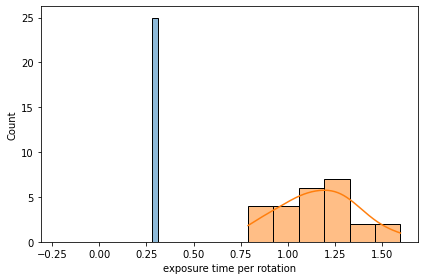

In [317]:
sns.histplot(df_heart_4D['exposure time per rotation'], bins=30,kde=True)
sns.histplot(df_heart_4D['exposure time'], kde=True)
plt.tight_layout()

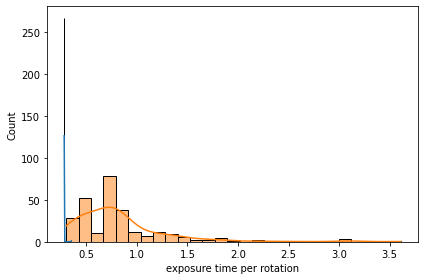

In [318]:
sns.histplot(df_heart_not_4D['exposure time per rotation'], bins=30,kde=True)
sns.histplot(df_heart_not_4D['exposure time'], kde=True)
plt.tight_layout()

<AxesSubplot:xlabel='exposure time', ylabel='Mean CTDIvol'>

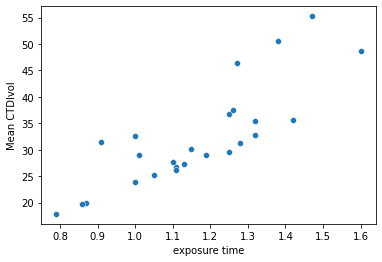

In [324]:
sns.scatterplot(x=df_heart_4D['exposure time'], y=df_heart_4D['Mean CTDIvol'])

<AxesSubplot:xlabel='exposure time', ylabel='Mean CTDIvol'>

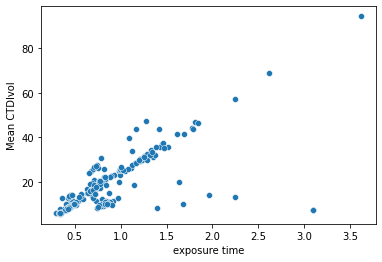

In [326]:
sns.scatterplot(x=df_heart_not_4D['exposure time'], y=df_heart_not_4D['Mean CTDIvol'])

In [333]:
test_heart = df[df['scan protocol'] == '5.41 CABG+CTA+180sDE']
test_heart

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,exposure time per rotation,exposure time,CTDIw phantom type,Mean CTDIvol,DLP,scan_date,id,age,gender,height(cm),weight(kg),scan_order,scan_method,bmi,bmr,category_bmi,age_era
8843,1348557720230306,5.41 CABG+CTA+180sDE,CTA,Chest,902.38,100,571.63,720,0.51,80,0.8,17.77,IEC Body Dosimetry Phantom,41.46,3740.93,2023-03-29,35371,74,M,172.0,75.2,冠動脈CT（ﾊﾞｲﾊﾟｽ有り）,造影,25.42,1461.12,obecity class1,70


In [351]:
test
calc_ctdi(test['kV'], test_heart['mean mA'], test_heart['exposure time per rotation'], test_heart['pitch factor']) 

8843    54.964466
dtype: float64

In [369]:
test = df[df['scan protocol'] == '1.13 Head Perfusion Routine']

In [370]:
test

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,exposure time per rotation,exposure time,CTDIw phantom type,Mean CTDIvol,DLP,scan_date,id,age,gender,height(cm),weight(kg),scan_order,scan_method,bmi,bmr,category_bmi,age_era
5496,1334695020230124,1.13 Head Perfusion Routine,Perfusion,Head,160.0,80,285.01,285,1.0,160,0.35,14.0,IEC Head Dosimetry Phantom,202.94,3247.07,2023-01-24,33843,77,F,147.0,31.20,脳CTA,CTA+Perfusion,14.44,865.36,under weight,70
7500,1213560220220105,1.13 Head Perfusion Routine,Perfusion,Head,160.0,80,285.56,285,1.0,160,0.35,14.0,IEC Head Dosimetry Phantom,203.34,3253.44,2022-01-07,7834005,85,M,169.0,89.35,脳CTA,CTA+Perfusion,31.28,1566.36,obecity class2,80
7551,1218862820220121,1.13 Head Perfusion Routine,Perfusion,Head,160.0,80,285.67,285,1.0,160,0.35,14.0,IEC Head Dosimetry Phantom,203.41,3254.60,2022-01-21,23165,36,M,165.0,73.20,脳CTA,CTA+Perfusion,26.89,1655.28,obecity class1,30
8497,1306101120221028,1.13 Head Perfusion Routine,Perfusion,Head,160.0,80,285.00,285,1.0,160,0.35,14.0,IEC Head Dosimetry Phantom,202.94,3246.99,2022-10-28,28175,70,M,168.5,61.90,脳CTA,CTA+Perfusion,21.80,1287.75,normal weight,70
8526,1309365020221108,1.13 Head Perfusion Routine,Perfusion,Head,160.0,80,285.01,285,1.0,160,0.35,14.0,IEC Head Dosimetry Phantom,202.94,3247.10,2022-11-18,1006614,51,M,173.0,68.00,脳CTA,CTA+Perfusion,22.72,1522.48,normal weight,50


In [366]:
df[df['scan protocol'].str.contains('^1.')]

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,exposure time per rotation,exposure time,CTDIw phantom type,Mean CTDIvol,DLP,scan_date,id,age,gender,height(cm),weight(kg),scan_order,scan_method,bmi,bmr,category_bmi,age_era
1727,1180331720210903,1.5 QQ Brain-Head Routine TFI-H,Helical,Head,210.74,100,289.01,411,0.52,40,0.8,8.17,IEC Head Dosimetry Phantom,44.31,933.74,2021-09-03,164531,78,M,158.0,45.6,脳CT,単純,18.27,957.05,under weight,70
1738,1171250820210803,1.9 Dental Helical 140kV Routine,Implant,Head,176.38,140,125.04,405,0.52,40,0.6,5.13,IEC Head Dosimetry Phantom,30.92,545.37,2021-09-06,18906,41,M,164.0,64.0,歯・顎骨CT,単純,23.80,1490.01,normal weight,40
1739,1172081720210805,1.9 Dental Helical 140kV Routine,Implant,Head,180.13,140,86.47,104,0.52,40,0.6,5.24,IEC Head Dosimetry Phantom,21.38,385.19,2021-09-06,8017704,27,M,165.0,65.0,歯・顎骨CT,単純,23.88,1603.33,normal weight,20
1751,1181021820210907,1.7 Brain Head Routine TFI-H,Helical,Head,205.73,100,193.16,228,0.52,40,0.8,7.98,IEC Head Dosimetry Phantom,29.61,609.27,2021-09-07,5885801,53,M,174.1,75.0,脳CT,単純,24.74,1610.73,normal weight,50
1759,1181457820210908,1.7 Brain Head Routine TFI-H,Helical,Head,185.73,100,160.13,208,0.52,40,0.8,7.20,IEC Head Dosimetry Phantom,24.55,455.97,2021-09-08,9974209,76,F,148.0,33.7,脳CT,単純,15.39,895.80,under weight,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8771,1339872220230208,1.11 Head CTA 1Volume SmartPrep Routine,Plain,Head,160.00,100,568.91,596,1.00,160,1.0,1.00,IEC Head Dosimetry Phantom,52.45,839.23,2023-03-03,9905506,71,M,169.5,71.0,脳CTA,CTA,24.71,1411.12,normal weight,70
8777,1340402820230209,1.11 Head CTA 1Volume SmartPrep Routine,Plain,Head,160.00,100,555.96,564,1.00,160,1.0,1.00,IEC Head Dosimetry Phantom,51.26,820.12,2023-03-03,1346220,44,M,167.0,54.4,脳CTA,CTA,19.51,1352.75,normal weight,40
8779,1340492120230209,1.5 QQ Brain-Head Routine TFI-H,Helical,Head,320.74,100,346.02,515,0.52,40,0.8,12.44,IEC Head Dosimetry Phantom,53.05,1701.55,2023-02-09,34682,82,M,176.0,55.3,脳CT,単純,17.85,1153.46,under weight,80
8786,1341516920230213,1.4 QQ Brain non-Helical Routine,Plain,Head,160.00,100,359.60,370,1.00,160,1.0,1.00,IEC Head Dosimetry Phantom,33.15,530.47,2023-02-13,34266,79,M,167.0,56.6,脳CT,単純,20.29,1146.58,normal weight,70


In [353]:
202.94/40

5.0735

In [361]:
df['nomial total collimation width'].sort_values()[:90]

7369     5
866      5
8100     5
4748     5
6218     5
        ..
2591     5
304      5
6512     5
5753    40
3592    40
Name: nomial total collimation width, Length: 90, dtype: int64

In [395]:
df = pd.read_excel('train_data.xlsx')
initial_preprocessing(df)
# df = duplicated_accession_CTDImax(df)
# df.reset_index(drop=True, inplace=Tru\e)
df = drop_emergency_suspicious_height_weight(df)
df.head(3)
df= df[~(df['nomial total collimation width'] == 5)]
df_duplicated = df[df['accession'].duplicated(keep=False)]

In [396]:
df_duplicated[df_duplicated['nomial total collimation width'] == 5]

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,exposure time per rotation,exposure time,CTDIw phantom type,Mean CTDIvol,DLP,scan_date,id,age,department,hospital_ward,gender,height(cm),weight(kg),scan_order,preset_name,modality,scan_method,adult_child


In [397]:
df_not_duplicated = df[~df['accession'].duplicated(keep=False)]

max_indices = df_duplicated.groupby('accession')['Mean CTDIvol'].idxmax()

result_df = df_duplicated.loc[max_indices].reset_index(drop=True)

df = pd.concat([df_not_duplicated, result_df], axis=0)

In [398]:
df['nomial total collimation width'].unique()

array([ 80.,  40., 160., 100., 130., 120., 110., 140., 150.])

In [421]:
df.reset_index(drop=True, inplace=True)

In [423]:
df.loc[df[df['scan protocol'].str.contains('Perfusion')].index, 'scan_order'] = '脳Perfusion'

In [424]:
df[df['scan protocol'].str.contains('Perfusion')]

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,exposure time per rotation,exposure time,CTDIw phantom type,Mean CTDIvol,DLP,scan_date,id,age,department,hospital_ward,gender,height(cm),weight(kg),scan_order,preset_name,modality,scan_method,adult_child
5481,1334695020230124,1.13 Head Perfusion Routine,Perfusion,Head,160.0,80,285.01,285,1.0,160.0,0.35,14.0,IEC Head Dosimetry Phantom,202.94,3247.07,2023-01-24,33843,77,脳神経外科,外来,F,147.0,31.20,脳Perfusion,撮影済のみ(ﾌﾟﾘｾｯﾄ無),Revolution,CTA+Perfusion,成人
7485,1213560220220105,1.13 Head Perfusion Routine,Perfusion,Head,160.0,80,285.56,285,1.0,160.0,0.35,14.0,IEC Head Dosimetry Phantom,203.34,3253.44,2022-01-07,7834005,85,脳神経外科,外来,M,169.0,89.35,脳Perfusion,撮影済のみ(ﾌﾟﾘｾｯﾄ無),Revolution,CTA+Perfusion,成人
7536,1218862820220121,1.13 Head Perfusion Routine,Perfusion,Head,160.0,80,285.67,285,1.0,160.0,0.35,14.0,IEC Head Dosimetry Phantom,203.41,3254.60,2022-01-21,23165,36,脳神経外科,６東,M,165.0,73.20,脳Perfusion,撮影済のみ(ﾌﾟﾘｾｯﾄ無),Revolution,CTA+Perfusion,成人
8482,1306101120221028,1.13 Head Perfusion Routine,Perfusion,Head,160.0,80,285.00,285,1.0,160.0,0.35,14.0,IEC Head Dosimetry Phantom,202.94,3246.99,2022-10-28,28175,70,脳神経外科,外来,M,168.5,61.90,脳Perfusion,撮影済のみ(ﾌﾟﾘｾｯﾄ無),Revolution,CTA+Perfusion,成人
8511,1309365020221108,1.13 Head Perfusion Routine,Perfusion,Head,160.0,80,285.01,285,1.0,160.0,0.35,14.0,IEC Head Dosimetry Phantom,202.94,3247.10,2022-11-18,1006614,51,脳神経外科,外来,M,173.0,68.00,脳Perfusion,撮影済のみ(ﾌﾟﾘｾｯﾄ無),Revolution,CTA+Perfusion,成人


In [574]:
df_heart = df[df['scan_order'].str.contains('心臓CT')]

160.0

In [575]:
df_heart['nomial total collimation width']

Series([], Name: nomial total collimation width, dtype: float64)

<AxesSubplot:xlabel='Mean CTDIvol', ylabel='Count'>

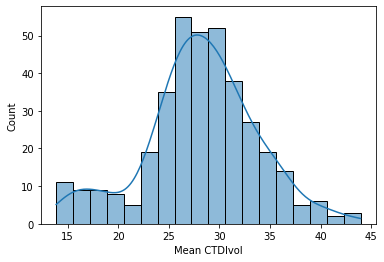

In [451]:
sns.histplot(df[df['scan_order'].str.contains('副鼻腔')]['Mean CTDIvol'], kde=True)

In [471]:
df[(df['scan_order'].str.contains('副鼻腔')) &  (df['Mean CTDIvol'] < 30)]

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,exposure time per rotation,exposure time,CTDIw phantom type,Mean CTDIvol,DLP,scan_date,id,age,department,hospital_ward,gender,height(cm),weight(kg),scan_order,preset_name,modality,scan_method,adult_child
16,1103737520210104,2.2 QQ Orbit Sinus Helical Routine,NaN,Eye region,160.81,100,228.03,330,0.52,40.0,0.6,4.68,IEC Head Dosimetry Phantom,26.19,421.21,2021-01-04,12643,52,呼吸器内科,外来,F,153.0,42.20,副鼻腔CT,256列 【枠外】副鼻腔CT（単純）,Revolution,単純,成人
17,1103559620210104,2.2 QQ Orbit Sinus Helical Routine,NaN,Eye region,173.32,100,256.16,330,0.52,40.0,0.6,5.04,IEC Head Dosimetry Phantom,29.42,509.99,2021-01-04,184105,74,耳鼻咽喉科,外来,F,152.0,50.60,副鼻腔CT,256列 【枠外】副鼻腔CT（単純）,Revolution,単純,成人
293,1115170220210204,2.4 Orbit Sinus Navigation Routine,NaN,Eye region,268.33,100,228.79,330,0.52,40.0,0.6,7.81,IEC Head Dosimetry Phantom,26.28,705.19,2021-02-08,4095110,52,耳鼻咽喉科,外来,M,165.0,67.60,副鼻腔CT,256列 副鼻腔CT（単純）,Revolution,単純,成人
304,1110346220210122,2.4 Orbit Sinus Navigation Routine,NaN,Eye region,268.27,100,203.89,330,0.52,40.0,0.7,9.11,IEC Head Dosimetry Phantom,27.32,733.02,2021-02-09,13119,46,耳鼻咽喉科,外来,M,176.0,71.45,副鼻腔CT,256列 副鼻腔CT（単純）,Revolution,単純,成人
312,1116706520210210,2.2 QQ Orbit Sinus Helical Routine,NaN,Eye region,170.81,100,247.04,283,0.52,40.0,0.6,4.97,IEC Head Dosimetry Phantom,28.38,484.71,2021-02-10,7927001,26,耳鼻咽喉科,外来,M,175.0,72.50,副鼻腔CT,256列 【枠外】副鼻腔CT（単純）,Revolution,単純,成人
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6185,1362993820230420,2.2 QQ Orbit Sinus Helical Routine,Plain,Head,173.32,100,152.80,191,0.52,40.0,0.6,5.04,IEC Head Dosimetry Phantom,17.57,304.52,2023-04-27,4176005,39,耳鼻咽喉科,外来,M,174.0,75.00,副鼻腔CT,256列 副鼻腔CT（単純）,Revolution,単純,成人
6196,1342461920230215,2.2 QQ Orbit Sinus Helical Routine,Plain,Head,173.32,100,173.25,330,0.52,40.0,0.6,5.04,IEC Head Dosimetry Phantom,19.92,345.27,2023-04-28,1226503,48,耳鼻咽喉科,外来,M,175.0,86.30,副鼻腔CT,256列 副鼻腔CT（単純）,Revolution,単純,成人
6813,1151208720210525,2.2 QQ Orbit Sinus Helical Routine,NaN,Eye region,280.77,100,203.42,330,0.52,40.0,0.7,9.53,IEC Head Dosimetry Phantom,27.26,765.41,2021-05-25,6686006,35,耳鼻咽喉科,外来,F,154.0,42.00,副鼻腔CT,256列 【枠外】副鼻腔CT（造影適宜）,Revolution,造影,成人
8466,1305092520221025,3.6 Neck CTA Helical SmartPrep Routine,Plain,Neck,329.44,100,315.72,700,0.98,40.0,0.6,5.02,IEC Head Dosimetry Phantom,19.02,626.44,2022-10-26,8736014,46,耳鼻咽喉科,外来,M,174.0,73.00,副鼻腔CT,256列 副鼻腔CT（造影適宜）,Revolution,造影,成人


In [474]:
df_orbit = df[df['scan_order'].str.contains('副鼻腔')]

In [483]:
df_orbit.groupby('target region').describe()['Mean CTDIvol']

,count,mean,std,min,25%,50%,75%,max
target region,,,,,,,,
Eye region,118.0,30.112373,4.381399,22.48,26.8125,29.505,32.735,42.53
Head,249.0,27.225904,5.846464,13.86,24.4400,27.630,30.470,43.94
Neck,1.0,19.020000,NaN,19.02,19.0200,19.020,19.020,19.02


<AxesSubplot:>

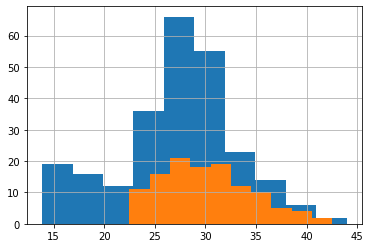

In [488]:
df_orbit[df_orbit['target region'] == 'Head']['Mean CTDIvol'].hist()
df_orbit[df_orbit['target region'] == 'Eye region']['Mean CTDIvol'].hist()

<AxesSubplot:>

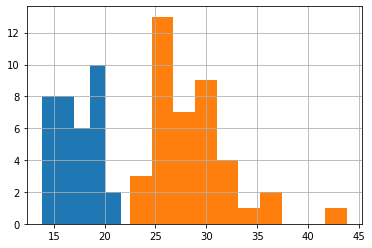

In [507]:
df_orbit[df_orbit['target region'] == 'Head'].sort_values('scan_date')[-40:]['Mean CTDIvol'].hist()
df_orbit[df_orbit['target region'] == 'Head'].sort_values('scan_date')[:40]['Mean CTDIvol'].hist()

In [515]:
df_orbit[df_orbit['target region'] == 'Eye region'].sort_values('scan_date').iloc[30]

accession                                           1116018820210208
scan protocol                     2.2 QQ Orbit Sinus Helical Routine
scan series                                                      NaN
target region                                             Eye region
scanning length                                               180.81
kV                                                               100
mean mA                                                       246.26
max mA                                                           283
pitch factor                                                    0.52
nomial total collimation width                                  40.0
exposure time per rotation                                       0.6
exposure time                                                   5.26
CTDIw phantom type                        IEC Head Dosimetry Phantom
Mean CTDIvol                                                   28.29
DLP                               

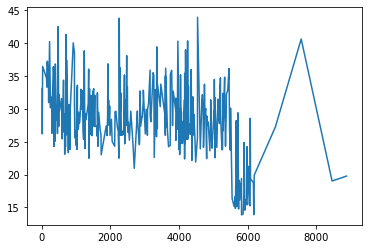

In [518]:
plt.plot('Mean CTDIvol', data=df_orbit)

In [519]:
df_orbit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368 entries, 12 to 8887
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   accession                       368 non-null    int64         
 1   scan protocol                   368 non-null    object        
 2   scan series                     250 non-null    object        
 3   target region                   368 non-null    object        
 4   scanning length                 368 non-null    float64       
 5   kV                              368 non-null    int64         
 6   mean mA                         368 non-null    float64       
 7   max mA                          368 non-null    int64         
 8   pitch factor                    368 non-null    float64       
 9   nomial total collimation width  368 non-null    float64       
 10  exposure time per rotation      368 non-null    float64       
 11  expo

In [560]:
df = pd.read_excel('train_data.xlsx')
initial_preprocessing(df)
# df = duplicated_accession_CTDImax(df)
# df.reset_index(drop=True, inplace=Tru\e)
df = drop_emergency_suspicious_height_weight(df)
duplicated_accession_CTDImax(df)

In [557]:
df_orbit = df[df['scan_order'].str.contains('副鼻腔')]

TypeError: 'NoneType' object is not subscriptable

In [558]:
len(df_orbit)

378

In [559]:
df

378

In [544]:
len(df_orbit)

378